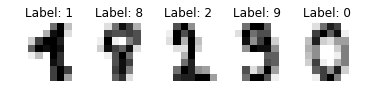

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
%matplotlib inline

digits = datasets.load_digits()
    
# To apply a classifier on this data, we need to flatten the image, to
# turn the data in a (samples, feature) matrix:
n_samples = len(digits.images)
mnist_data = digits.images.reshape((n_samples, -1)).astype(float)
labels = digits.target.astype(int)

# choose some random images to display
indices = np.arange(len(digits.images))
display = np.random.choice(indices, size=5)

for i, image in enumerate(digits.images[display]):
    plt.subplot(1, 5, i+1)
    plt.axis('off')
    plt.imshow(image, cmap=plt.cm.gray_r, interpolation='nearest')
    plt.title("Label: %d" % digits.target[display[i]])
plt.show()


In [2]:
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split

onehot_labels = to_categorical(labels)

train_to_test_ratio = 0.8
X_train, X_test, Y_train, Y_test = train_test_split(mnist_data, onehot_labels, train_size=train_to_test_ratio)


Using TensorFlow backend.
/home/andreas/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [3]:
from sklearn.metrics import accuracy_score

epochs = 100
batch_size = 100
n_features = X_train.shape[1]
n_neurons_layer1 = 100
n_neurons_layer2 = 50
n_categories = 10


In [4]:
from keras.models import Sequential
from keras.layers import Dense

def create_DNN(n_features, n_neurons_layer1, n_neurons_layer2, n_categories):
    model = Sequential()
    model.add(Dense(n_neurons_layer1, input_dim=n_features, activation='sigmoid'))
    model.add(Dense(n_neurons_layer1, activation='sigmoid'))
    model.add(Dense(n_categories, activation='softmax'))
    
    model.compile(loss='categorical_crossentropy', optimizer='SGD', metrics=['accuracy'])
    
    return model

model = create_DNN(n_features, n_neurons_layer1, n_neurons_layer2, n_categories)
model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size, verbose=0)

scores = model.evaluate(X_test, Y_test)
print("Accuracy: %.3f" % scores[1])

360/360 [==============================] - 0s 52us/step
Accuracy: 0.892


In [5]:
import torch
from torchvision import datasets, transforms

mnist_trainset = datasets.MNIST('../data/torch/mnist', train=True, download=True, transform=transforms.ToTensor())
train_loader = torch.utils.data.DataLoader(mnist_trainset, batch_size=batch_size, shuffle=True)

mnist_testset = datasets.MNIST('../data/torch/mnist', train=False, download=True, transform=transforms.ToTensor())
test_loader = torch.utils.data.DataLoader(mnist_testset, batch_size=batch_size, shuffle=False)


In [6]:
import torch.nn as nn
import torch.nn.functional as F

class DNNTorch(nn.Module):
    def __init__(
        self,
        n_features,
        n_neurons_layer1=100,
        n_neurons_layer2=50,
        n_categories=2,
    ):
        super(DNNTorch, self).__init__()
        self.fc1 = nn.Linear(n_features, n_neurons_layer1)
        self.fc2 = nn.Linear(n_neurons_layer1, n_neurons_layer2)
        self.out = nn.Linear(n_neurons_layer2, n_categories)
    
    def forward(self, x):
        x = F.sigmoid(self.fc1(x))
        x = F.sigmoid(self.fc2(x))
        x = self.out(x)
        return x

In [7]:
import torch.optim as optim
from torch.autograd import Variable

n_features = 28*28
epochs = 2

DNN = DNNTorch(n_features, n_neurons_layer1, n_neurons_layer2, n_categories)
DNN.zero_grad()

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(DNN.parameters(), lr=0.1)

for epoch in range(epochs):
    running_loss = 0.0
    for i, data, in enumerate(train_loader):
        inputs, labels = data
        inputs = inputs.view(-1, n_features)
        inputs, labels = Variable(inputs), Variable(labels)
        
        optimizer.zero_grad()
        output = DNN(inputs)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % batch_size == batch_size - 1:
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / batch_size))
            running_loss = 0.0

print('Finished Training')

correct = 0
total = 0
with torch.no_grad():
    for data in test_loader:
        inputs, labels = data
        inputs = inputs.view(-1, n_features)
        outputs = DNN(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the test images: %d %%' % (
    100 * correct / total))

[1,   100] loss: 2.302
[1,   200] loss: 2.295
[1,   300] loss: 2.284
[1,   400] loss: 2.267
[1,   500] loss: 2.231
[1,   600] loss: 2.135
[2,   100] loss: 1.924
[2,   200] loss: 1.652
[2,   300] loss: 1.419
[2,   400] loss: 1.251
[2,   500] loss: 1.087
[2,   600] loss: 0.951
Finished Training
Accuracy of the network on the test images: 75 %
